In [ ]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd

# load environment (use dev unless told otherwise)
load_dotenv("../.env.dev")

DB_NAME = os.getenv("SOURCE_DB_NAME")
DB_USER = os.getenv("SOURCE_DB_USER")
DB_PASSWORD = os.getenv("SOURCE_DB_PASSWORD")
DB_HOST = os.getenv("SOURCE_DB_HOST")
DB_PORT = os.getenv("SOURCE_DB_PORT")

engine = create_engine(
    f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

engine.connect()


In [ ]:
revenue_df = pd.read_sql(
    """
    SELECT
        c.store_id,
        SUM(p.amount) AS total_revenue
    FROM (
        SELECT DISTINCT payment_id
        FROM main.payment
    ) dp
    JOIN main.payment p ON p.payment_id = dp.payment_id
    JOIN main.customer c ON p.customer_id = c.customer_id
    GROUP BY c.store_id
    ORDER BY c.store_id;
    """,
    engine
)

print(revenue_df)


   store_id  total_revenue
0         1       33621.42
1         2       27690.62


In [ ]:
customers_df = pd.read_sql(
    """
    SELECT
        c.store_id,
        COUNT(DISTINCT p.customer_id) AS unique_customers
    FROM main.payment p
    JOIN main.customer c ON p.customer_id = c.customer_id
    GROUP BY c.store_id
    ORDER BY c.store_id;
    """,
    engine
)


customers_df



,store_id,unique_customers
0,1,326
1,2,273


In [ ]:
transactions_df = pd.read_sql(
    """
    SELECT
        c.store_id,
        COUNT(DISTINCT p.payment_id) AS total_payments
    FROM main.payment p
    JOIN main.customer c ON p.customer_id = c.customer_id
    GROUP BY c.store_id
    ORDER BY c.store_id;
    """,
    engine
)

print(transactions_df)

   store_id  total_payments
0         1            7958
1         2            6638


In [ ]:
category_df = pd.read_sql(
    """
    SELECT
        c.store_id,
        cat.name AS category,
        SUM(p.amount) AS revenue
    FROM (
        SELECT DISTINCT payment_id, rental_id, amount, customer_id
        FROM main.payment
    ) p
    JOIN main.customer c ON p.customer_id = c.customer_id
    JOIN main.rental r ON p.rental_id = r.rental_id
    JOIN main.inventory i ON r.inventory_id = i.inventory_id
    JOIN main.film f ON i.film_id = f.film_id
    JOIN main.film_category fc ON f.film_id = fc.film_id
    JOIN main.category cat ON fc.category_id = cat.category_id
    GROUP BY c.store_id, cat.name
    ORDER BY c.store_id, revenue DESC;
    """,
    engine
)

category_df




,store_id,category,revenue
0,1,Sports,2744.96
1,1,Sci-Fi,2468.37
2,1,Animation,2416.88
3,1,Drama,2316.77
4,1,Comedy,2263.23
5,1,New,2229.18
6,1,Foreign,2132.91
7,1,Games,2125.22
8,1,Action,2095.75
9,1,Documentary,2058.97


In [ ]:
location_df = pd.read_sql(
    """
    SELECT
        s.store_id,
        ci.city,
        co.country
    FROM main.store s
    JOIN main.address a ON s.address_id = a.address_id
    JOIN main.city ci ON a.city_id = ci.city_id
    JOIN main.country co ON ci.country_id = co.country_id;
    """,
    engine
)

location_df


,store_id,city,country
0,1,Lethbridge,Canada
1,2,Woodridge,Australia


In [ ]:
summary_df = (
    revenue_df
    .merge(customers_df, on="store_id")
    .merge(location_df, on="store_id")
)

summary_df


,store_id,total_revenue,unique_customers,city,country
0,1,33621.42,326,Lethbridge,Canada
1,2,27690.62,273,Woodridge,Australia


In [ ]:
store1_pie = category_df[category_df["store_id"] == 1]
store1_pie


,store_id,category,revenue
0,1,Sports,2744.96
1,1,Sci-Fi,2468.37
2,1,Animation,2416.88
3,1,Drama,2316.77
4,1,Comedy,2263.23
5,1,New,2229.18
6,1,Foreign,2132.91
7,1,Games,2125.22
8,1,Action,2095.75
9,1,Documentary,2058.97


In [ ]:
store2_pie = category_df[category_df["store_id"] == 2]
store2_pie


,store_id,category,revenue
16,2,Sports,2147.23
17,2,Sci-Fi,1867.64
18,2,Family,1856.39
19,2,Action,1856.09
20,2,Animation,1828.43
21,2,Drama,1801.69
22,2,Foreign,1801.56
23,2,Games,1796.96
24,2,Comedy,1739.25
25,2,New,1737.20


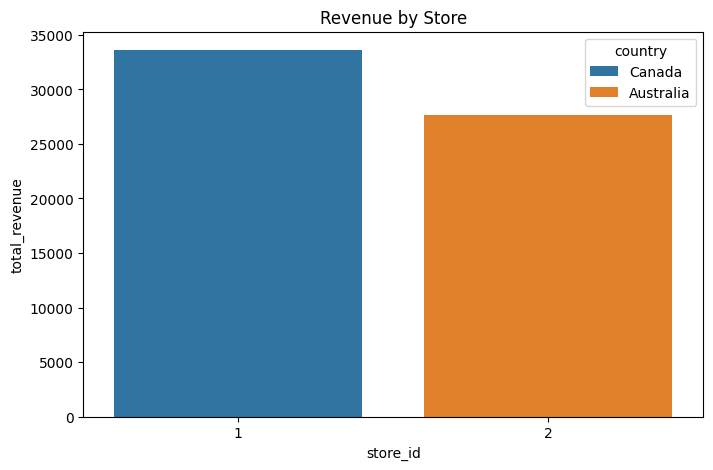

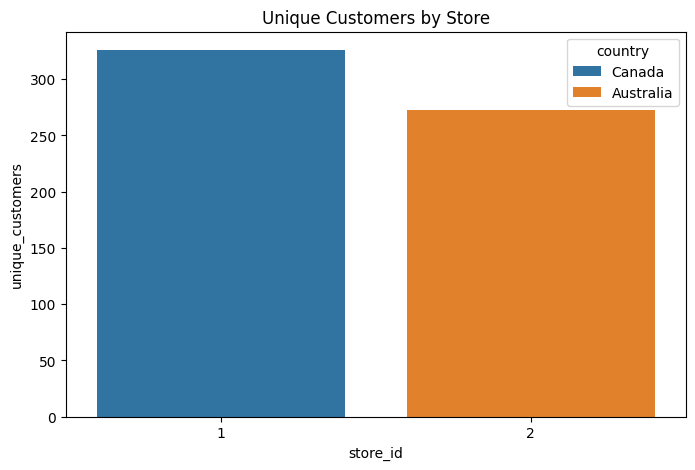

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(
    data=summary_df,
    x="store_id",
    y="total_revenue",
    hue="country"
)
plt.title("Revenue by Store")
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(
    data=summary_df,
    x="store_id",
    y="unique_customers",
    hue="country"
)
plt.title("Unique Customers by Store")
plt.show()


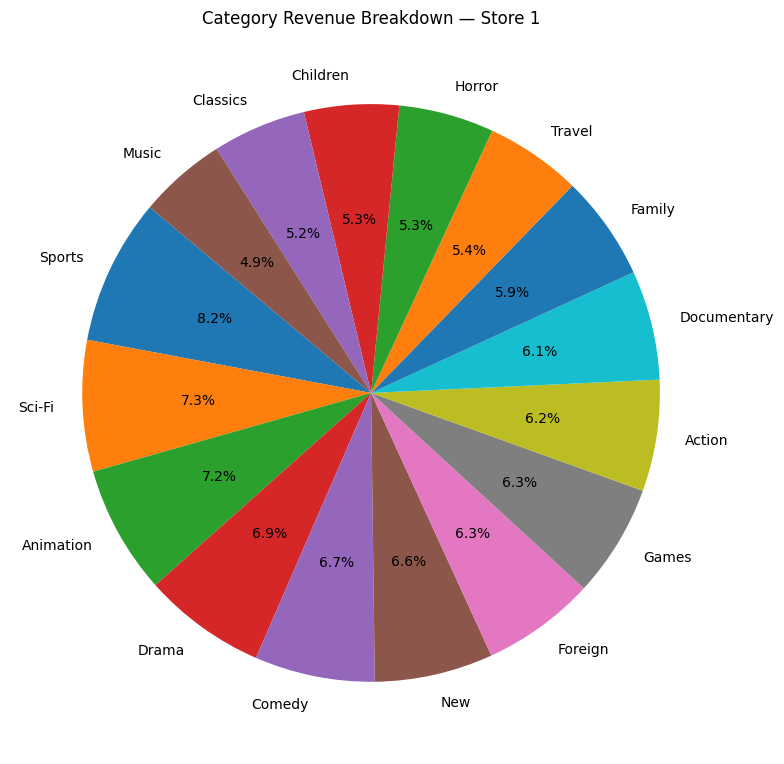

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(
    store1_pie["revenue"],
    labels=store1_pie["category"],
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Category Revenue Breakdown — Store 1")
plt.tight_layout()
plt.show()


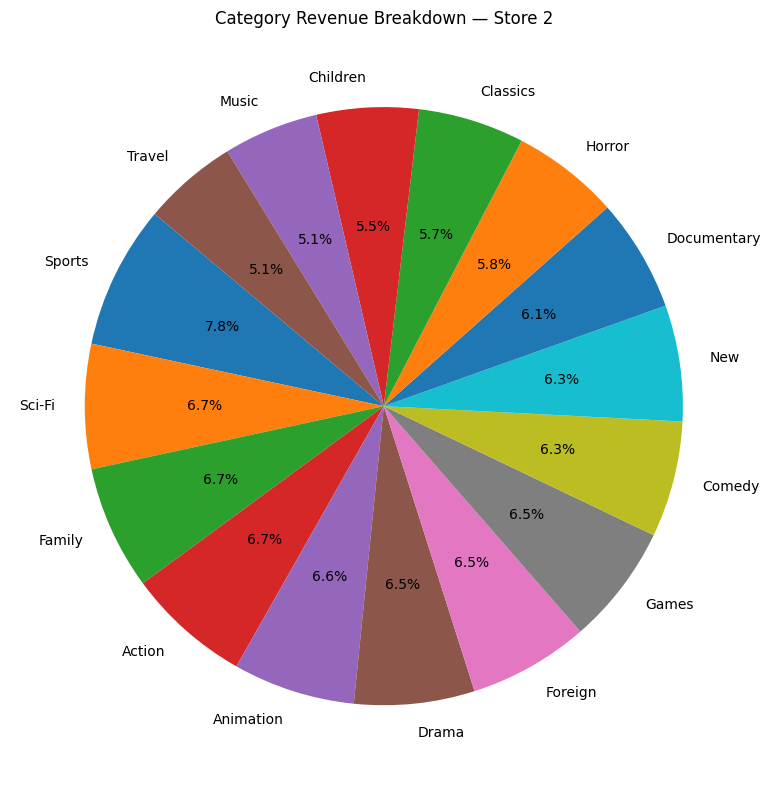

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(
    store2_pie["revenue"],
    labels=store2_pie["category"],
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Category Revenue Breakdown — Store 2")
plt.tight_layout()
plt.show()
